# 1. Importing all neccessary libraries(again)

## 1.1: Install tensorflow for training Neural Networks and keras_tuner for Hyperparameter Tuning

In [4]:
!pip install tensorflow
!pip install keras_tuner

## 1.2: Installing other libraries

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 2. Load Raw Data
We load the raw sensor data and corresponding activity labels from the UCI HAR dataset files.

In [8]:
# File paths for raw data
train_file_path = "UCI HAR Dataset/train/X_train.txt"
train_labels_path = "UCI HAR Dataset/train/y_train.txt"
test_file_path = "UCI HAR Dataset/test/X_test.txt"
test_labels_path = "UCI HAR Dataset/test/y_test.txt"

# Load sensor data
X_train_raw = pd.read_csv(train_file_path, delim_whitespace=True, header=None)
X_test_raw = pd.read_csv(test_file_path, delim_whitespace=True, header=None)

# Load activity labels
y_train_raw = pd.read_csv(train_labels_path, header=None)
y_test_raw = pd.read_csv(test_labels_path, header=None)

print("Data Shapes:")
print(f"X_train: {X_train_raw.shape}, y_train: {y_train_raw.shape}")
print(f"X_test: {X_test_raw.shape}, y_test: {y_test_raw.shape}")

C:\Users\susha\AppData\Local\Temp\ipykernel_11120\3650518382.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train_raw = pd.read_csv(train_file_path, delim_whitespace=True, header=None)
C:\Users\susha\AppData\Local\Temp\ipykernel_11120\3650518382.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test_raw = pd.read_csv(test_file_path, delim_whitespace=True, header=None)


Data Shapes:
X_train: (7352, 561), y_train: (7352, 1)
X_test: (2947, 561), y_test: (2947, 1)


# 3. Feature Naming and Inspection
Assining column names using the features.txt file for easier handling and visualization of data.

In [10]:
# Load feature names
features = pd.read_csv('UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)
feature_names = features[1].values

# Assign feature names to the sensor data
X_train_raw.columns = feature_names
X_test_raw.columns = feature_names

# Inspect a sample of the raw data
X_train_raw.head()

C:\Users\susha\AppData\Local\Temp\ipykernel_11120\1907289550.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features = pd.read_csv('UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


# 4. Data Normalization
We normalize the raw features using StandardScaler to ensure all features have zero mean and unit variance.

In [12]:
# Initialize the scaler
scaler = StandardScaler()

# Normalize training and testing data
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# 5. Data Normalization
We normalize the raw features using StandardScaler to ensure all features have zero mean and unit variance.

In [14]:
# Window size for LSTM (number of time steps)
window_size = 100

# Create sequences
X_train_seq = []
y_train_seq = []
X_test_seq = []
y_test_seq = []

# Generate sequences from training data
for i in range(len(X_train_scaled) - window_size):
    X_train_seq.append(X_train_scaled[i:i+window_size])
    y_train_seq.append(y_train_raw.iloc[i+window_size, 0])

# Generate sequences from test data
for i in range(len(X_test_scaled) - window_size):
    X_test_seq.append(X_test_scaled[i:i+window_size])
    y_test_seq.append(y_test_raw.iloc[i+window_size, 0])

# Convert to numpy arrays
X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)
X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

print("Reshaped Data Shapes:")
print(f"X_train_seq: {X_train_seq.shape}, y_train_seq: {y_train_seq.shape}")
print(f"X_test_seq: {X_test_seq.shape}, y_test_seq: {y_test_seq.shape}")

Reshaped Data Shapes:
X_train_seq: (7252, 100, 561), y_train_seq: (7252,)
X_test_seq: (2847, 100, 561), y_test_seq: (2847,)


# 6. Build the LSTM Model [Initial Random Try]
We create a sequential model with an LSTM layer, followed by a dropout layer for regularization and dense layers for output.

In [16]:
# Build the LSTM model
model = Sequential()

# Add LSTM layer
model.add(LSTM(units=128, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))

# Add Dropout for regularization
model.add(Dropout(0.2))

# Add Dense layers
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=len(np.unique(y_train_seq)), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       353,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,926 (1.38 MB)

 Trainable params: 361,926 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train the LSTM Model 
Fitted the model using the training data, validating with the test set, and monitor accuracy over epochs.

In [18]:
# Shift labels to start from 0
y_train_seq -= 1
y_test_seq -= 1

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=64, validation_data=(X_test_seq, y_test_seq), verbose=1)


Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.8112 - loss: 0.6106 - val_accuracy: 0.9290 - val_loss: 0.2418
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9571 - loss: 0.1775 - val_accuracy: 0.9382 - val_loss: 0.1977
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.9554 - loss: 0.1668 - val_accuracy: 0.9340 - val_loss: 0.2101
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.9583 - loss: 0.1505 - val_accuracy: 0.9470 - val_loss: 0.1882
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.9579 - loss: 0.1445 - val_accuracy: 0.9385 - val_loss: 0.1944
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.9645 - loss: 0.1272 - val_accuracy: 0.9224 - val_loss: 0.2403
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.9626 - loss: 0.1257 - val_accuracy: 0.9371 - val_loss: 0.1924
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.9611 - loss: 0.1275 - 

# 8. Evaluate the Model
Evaluate the model's performance on the test set and print the accuracy.

In [20]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test_seq)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9386 - loss: 0.1859
Test Accuracy: 93.43%


# 9. Minor Visualizations


## 9.1: Training and Validation Accuracy
A graph to plot the train and test accuracies and loss over different Epochs

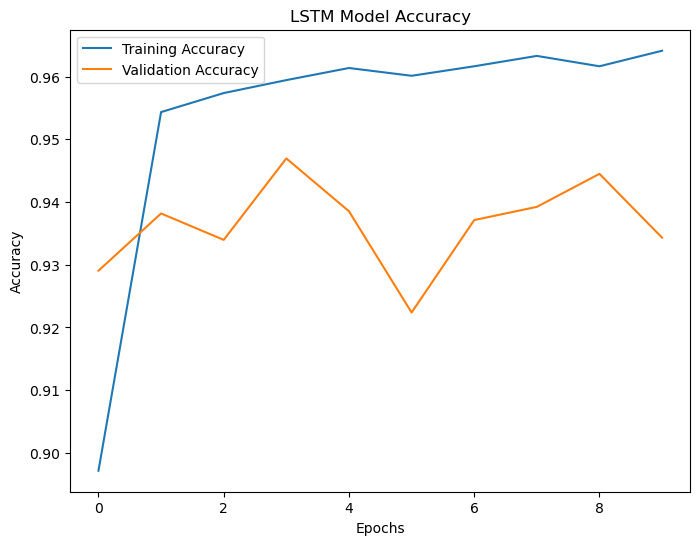

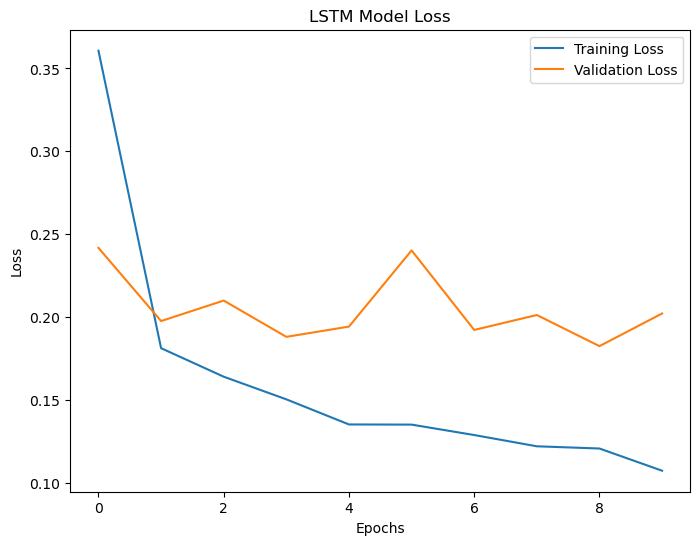

In [23]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 9.2: Confusion Matrix
Generated a confusion matrix to analyze how well the model classifies each activity.

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


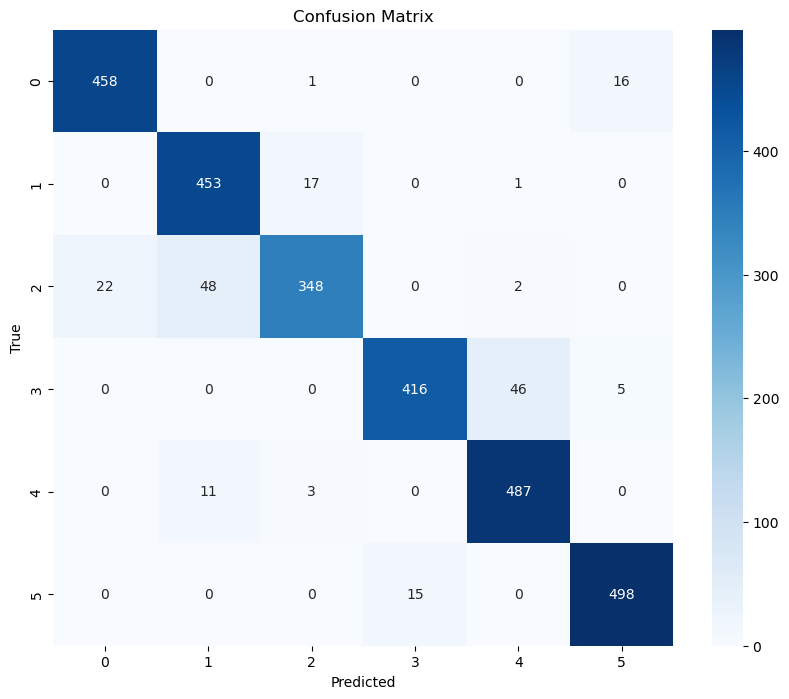

In [25]:
# Predict the activity for test data
y_pred = model.predict(X_test_seq)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to labels

conf_matrix = confusion_matrix(y_test_seq, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train_seq), yticklabels=np.unique(y_train_seq))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# HYPER PARAMETER TUNING [CHECKING FOR THE BEST MODEL]
To optimize the performance of LSTM model,I tuned key hyperparameters like the number of LSTM units, dropout rates, learning rate, batch size, and the number of epochs using Keras Tuner.

**Key Hyperparameters to Tune:**
- **LSTM Units**: Number of neurons in each LSTM layer (e.g., 32, 64, 128).
- **Dropout**: Regularization technique to prevent overfitting (e.g., 0.2, 0.3, 0.5).
- **Learning Rate**: Step size for weight updates (e.g., 0.001, 0.01).
- **Batch Size**: Number of samples per training batch (e.g., 32, 64, 128).
- **Epochs**: Number of times the model trains on the entire dataset.

## 1: Set Up Keras Tuner and Define the Search Space:

In [29]:

# Define the model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(6, activation='softmax')) 

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.0001])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## 2: Run the Tuner

In [31]:
# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of combinations to try
    executions_per_trial=1,  # Number of times to train each model
    directory='tuning_dir',
    project_name='lstm_hyperparameter_tuning'
)

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform the search
tuner.search(X_train_seq, y_train_seq, epochs=20, validation_data=(X_test_seq, y_test_seq), batch_size=64, callbacks=[early_stopping])

Reloading Tuner from tuning_dir\lstm_hyperparameter_tuning\tuner0.json


## 3: Tuning Results

In [33]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best number of LSTM neurons: {best_hps.get('units')}
Best dropout rate: {best_hps.get('dropout')}
Best learning rate: {best_hps.get('learning_rate')}
""")


Best number of LSTM neurons: 128
Best dropout rate: 0.4
Best learning rate: 0.0001



## 4: Visualize Tuning Results

### 4.1: Training and Validation Accuracy Plot

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\susha\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9630 - loss: 0.1033 - val_accuracy: 0.9449 - val_loss: 0.1587
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.9694 - loss: 0.0856 - val_accuracy: 0.9449 - val_loss: 0.1654
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.9709 - loss: 0.0875 - val_accuracy: 0.9459 - val_loss: 0.1569
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.9674 - loss: 0.0870 - val_accuracy: 0.9420 - val_loss: 0.1633
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9688 - loss: 0.0847 - val_accuracy: 0.9442 - val_loss: 0.1611
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.9753 - loss: 0.0716 - val_accuracy: 0.9477 - val_loss: 0.1504
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9676 - loss: 0.0810 - val_accuracy: 0.9375 - val_loss: 0.1739
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.9707 - loss: 0.0756 

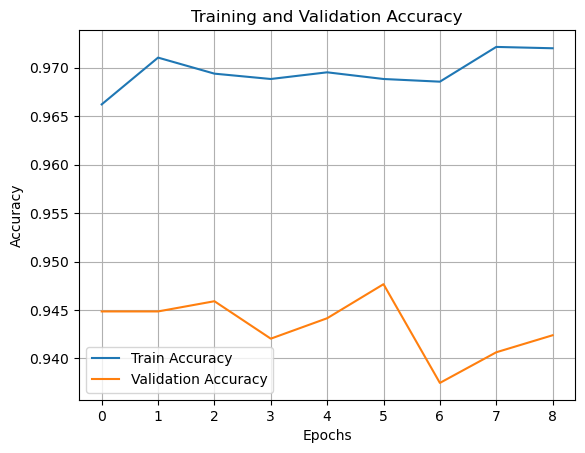

In [36]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model further
history = best_model.fit(
    X_train_seq, y_train_seq, 
    epochs=20, 
    validation_data=(X_test_seq, y_test_seq), 
    batch_size=64, 
    callbacks=[early_stopping]
)

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### 4.2: Training and Validation Loss Plot

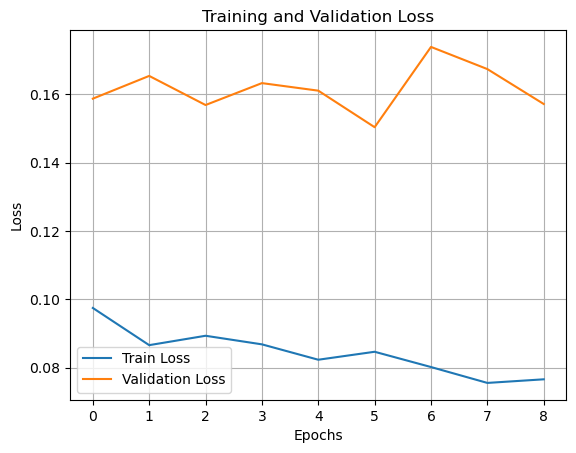

In [38]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


## 5: FINAL MODEL EVALUATION 

In [40]:
# Evaluate the model on test data
test_loss, test_acc = best_model.evaluate(X_test_seq, y_test_seq)
print(f"Test Accuracy: {test_acc:.4f}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9440 - loss: 0.1654
Test Accuracy: 0.9477


## 6: Visualize Hyperparameter Search Results

### 6.1: Hyperparameter Search Summary: 

In [43]:
tuner.results_summary()


Results summary
Results in tuning_dir\lstm_hyperparameter_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
units: 128
dropout: 0.4
learning_rate: 0.0001
Score: 0.9483667016029358

Trial 09 summary
Hyperparameters:
units: 96
dropout: 0.30000000000000004
learning_rate: 0.001
Score: 0.9483667016029358

Trial 00 summary
Hyperparameters:
units: 32
dropout: 0.4
learning_rate: 0.001
Score: 0.9459079504013062

Trial 07 summary
Hyperparameters:
units: 128
dropout: 0.5
learning_rate: 0.0001
Score: 0.9448542594909668

Trial 06 summary
Hyperparameters:
units: 96
dropout: 0.30000000000000004
learning_rate: 0.0001
Score: 0.9392342567443848

Trial 08 summary
Hyperparameters:
units: 64
dropout: 0.30000000000000004
learning_rate: 0.01
Score: 0.9388830065727234

Trial 02 summary
Hyperparameters:
units: 128
dropout: 0.5
learning_rate: 0.01
Score: 0.9371268153190613

Trial 04 summary
Hyperparameters:
units: 64
dropout: 0.1
learning_rate: 0.01

### 6.2: Plot Hyperparameter Tuning Results:
**Extracted trial results and visualize hyperparameter relationships with metrics like validation accuracy.**

In [45]:
# Retrieve all trials and their scores
trials = tuner.oracle.get_best_trials(num_trials=10)  

# Collect hyperparameters and metrics
trial_metrics = []
for trial in trials:
    trial_metrics.append({
        'units': trial.hyperparameters.get('units'),
        'dropout': trial.hyperparameters.get('dropout'),
        'learning_rate': trial.hyperparameters.get('learning_rate'),
        'val_accuracy': trial.metrics.get_last_value('val_accuracy')
    })


**Visualize Tuning Results and Plotting Hyperparameter Combinations vs. Validation Accuracy**

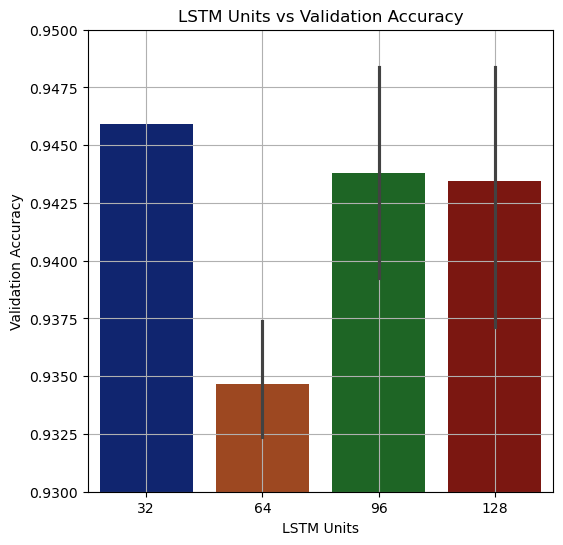

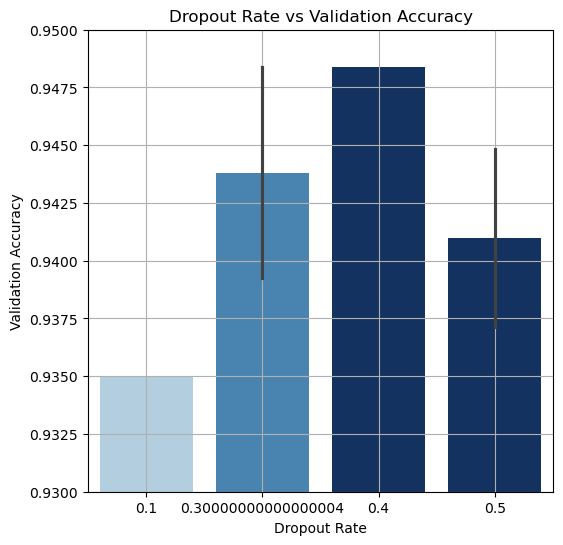

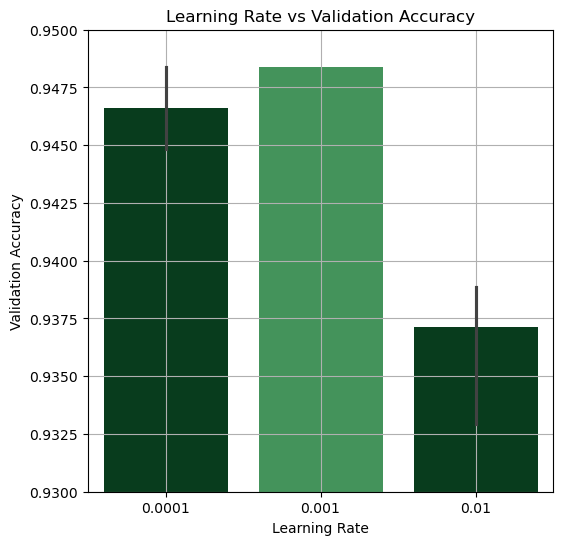

In [47]:

# Convert trial data to DataFrame
df = pd.DataFrame(trial_metrics)
units_palette = sns.color_palette("dark", n_colors=df['units'].nunique())

# Plot units vs validation accuracy
plt.figure(figsize=(6, 6))
sns.barplot(x='units', y='val_accuracy', hue= 'units',data=df , palette= units_palette , dodge=False,legend=False)
plt.title('LSTM Units vs Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('LSTM Units')
plt.ylim(0.93, 0.95)
plt.grid()
plt.show()

# Plot dropout vs validation accuracy
plt.figure(figsize=(6, 6))
sns.barplot(x='dropout', y='val_accuracy',hue= 'units', data=df , palette='Blues',  dodge=False,legend=False)
plt.title('Dropout Rate vs Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Dropout Rate')
plt.ylim(0.93, 0.95)
plt.grid()
plt.show()

# Plot learning rate vs validation accuracy
plt.figure(figsize=(6, 6))
sns.barplot(x='learning_rate', y='val_accuracy', hue= 'units',data=df , palette='Greens',  dodge=False,legend=False)
plt.title('Learning Rate vs Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylim(0.93, 0.95)
plt.grid()
plt.show()


**Pairplot for Multi-Dimensional Relationships To analyze how different hyperparameters interact:**

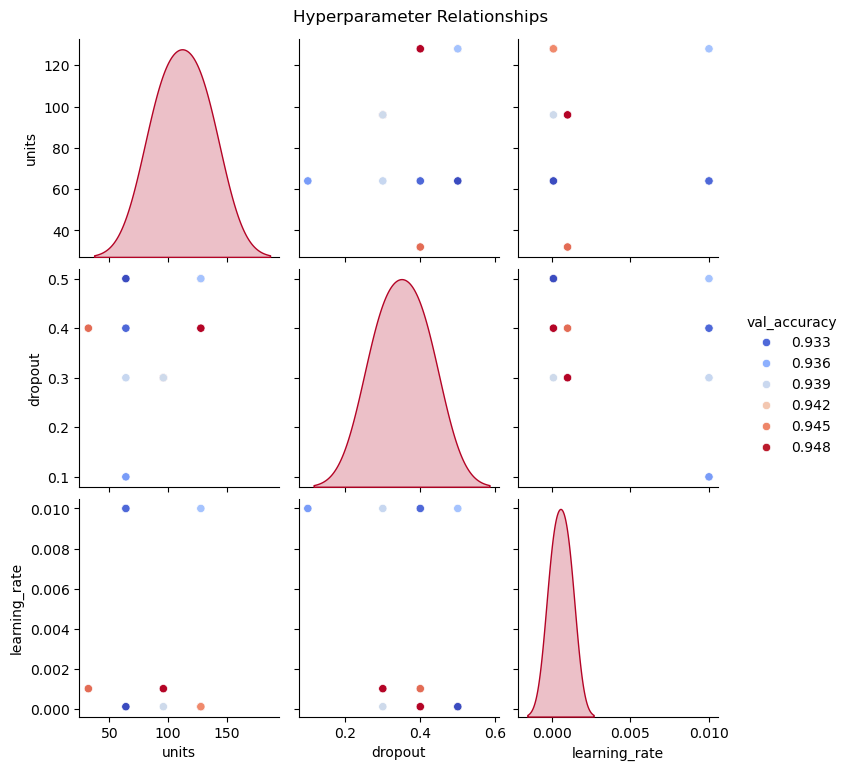

In [49]:
# Pairplot to visualize relationships between all hyperparameters and val_accuracy
sns.pairplot(df, hue='val_accuracy', palette='coolwarm')
plt.suptitle('Hyperparameter Relationships', y=1.02)
plt.show()